In [ ]:
#%pip install git+https://github.com/TattaBio/DGEB.git
#%pip install gffutils
#%pip install shap
#%pip install sentencepiece
#%pip install huggingface_hub hf_xet ipywidgets

In [2]:
from dgeb.tasks import EcoliOperon, PairClassificationEvaluator
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from Bio import SeqIO, motifs
from Bio.Seq import Seq
import gzip
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
import shap
import matplotlib.pyplot as plt

In [3]:
#help(EcoliOperon.metadata)
#print(EcoliOperon.metadata)
task = EcoliOperon()
hf_ds = load_dataset(task.metadata.datasets[0].path)
df = pd.DataFrame(hf_ds["train"])
display(df.head())

,Entry,Sequence,Label
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,1
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,0
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0


In [4]:
def extract_protein_id(entry):
    """Extracts the protein identifier from the Entry string."""
    match = re.search(r"U00096\.3_prot_([A-Z0-9]+\.\d+)", entry)
    if match:
        return match.group(1)
    else:
        return None

def calculate_gc_content(sequence):
    """Calculates the GC content of a DNA sequence."""
    if not sequence:
        return 0.0
    gc_count = sequence.count('G') + sequence.count('C')
    return gc_count / len(sequence)

def create_pairs(df):
    """Creates pairs of consecutive proteins from the DataFrame."""
    pairs = []
    for i in range(len(df) - 1):
        protein_A = df.iloc[i]
        protein_B = df.iloc[i + 1]
        pairs.append({
            "Entry_A": protein_A["Entry"],
            "Sequence_A": protein_A["Sequence"],
            "Entry_B": protein_B["Entry"],
            "Sequence_B": protein_B["Sequence"],
            "Label": protein_A["Label"]  # Assuming Label refers to the relationship between A and B
        })
    return pd.DataFrame(pairs)

In [5]:
# Extract protein IDs
df['protein_id'] = df['Entry'].apply(extract_protein_id)
df = df.dropna(subset=['protein_id'])

# Create protein pairs
pairs_df = create_pairs(df.copy()) # Pass a copy to avoid modifying original df

# Calculate GC-content for each protein
df['gc_content'] = df['Sequence'].apply(calculate_gc_content)

# Merge GC-content into the pairs_df
pairs_df = pairs_df.merge(df[['Entry', 'gc_content']], left_on='Entry_A', right_on='Entry', how='left')
pairs_df = pairs_df.rename(columns={'gc_content': 'gc_content_A'})
pairs_df = pairs_df.drop(columns=['Entry'])

pairs_df = pairs_df.merge(df[['Entry', 'gc_content']], left_on='Entry_B', right_on='Entry', how='left')
pairs_df = pairs_df.rename(columns={'gc_content': 'gc_content_B'})
pairs_df = pairs_df.drop(columns=['Entry'])

pairs_df['gc_content_difference'] = pairs_df['gc_content_A'] - pairs_df['gc_content_B']

# Display the result
print("\nPairs DataFrame with GC-content difference:")
display(pairs_df.head())


Pairs DataFrame with GC-content difference:


,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,gc_content_A,gc_content_B,gc_content_difference
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,0.142857,0.091463,0.051394
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,0.091463,0.116129,-0.024666
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,0.116129,0.074766,0.041363
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,0.074766,0.112245,-0.037479
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,0.112245,0.054054,0.058191


In [6]:
def load_genbank_annotations(gbff_file):
    """Parse GenBank file to extract gene annotations."""
    gene_annotations = {}
    for record in SeqIO.parse(gbff_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":  # Look for coding sequences (CDS)
                protein_id = feature.qualifiers.get('protein_id', [None])[0]
                if protein_id:
                    gene_annotations[protein_id] = {
                        'start': feature.location.start,
                        'end': feature.location.end,
                        'strand': feature.location.strand
                    }
    return gene_annotations

# Load gene annotations from the GenBank file
gbff_file_path = gzip.open('data/GCF_000005845.2_ASM584v2_genomic.gbff.gz', 'rt')
gene_annotations = load_genbank_annotations(gbff_file_path)

# Check a sample of the annotations
print(list(gene_annotations.items())[:5])  # Print the first 5 entries

[('NP_414542.1', {'start': ExactPosition(189), 'end': ExactPosition(255), 'strand': 1}), ('NP_414543.1', {'start': ExactPosition(336), 'end': ExactPosition(2799), 'strand': 1}), ('NP_414544.1', {'start': ExactPosition(2800), 'end': ExactPosition(3733), 'strand': 1}), ('NP_414545.1', {'start': ExactPosition(3733), 'end': ExactPosition(5020), 'strand': 1}), ('NP_414546.1', {'start': ExactPosition(5233), 'end': ExactPosition(5530), 'strand': 1})]


In [7]:
def load_protein_sequences(fasta_file):
    """Load protein sequences from a FASTA file."""
    protein_sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        protein_id = record.id
        sequence = str(record.seq)
        protein_sequences[protein_id] = sequence
    return protein_sequences

# Load protein sequences from the FASTA file
fasta_file_path = gzip.open('data/GCF_000005845.2_ASM584v2_protein.faa.gz', 'rt')
protein_sequences = load_protein_sequences(fasta_file_path)

# Check a sample of protein sequences
print(list(protein_sequences.items())[:5])  # Print the first 5 protein sequences

[('NP_414542.1', 'MKRISTTITTTITITTGNGAG'), ('NP_414543.1', 'MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNHLVAMIEKTISGQDALPNISDAERIFAELLTGLAAAQPGFPLAQLKTFVDQEFAQIKHVLHGISLLGQCPDSINAALICRGEKMSIAIMAGVLEARGHNVTVIDPVEKLLAVGHYLESTVDIAESTRRIAASRIPADHMVLMAGFTAGNEKGELVVLGRNGSDYSAAVLAACLRADCCEIWTDVDGVYTCDPRQVPDARLLKSMSYQEAMELSYFGAKVLHPRTITPIAQFQIPCLIKNTGNPQAPGTLIGASRDEDELPVKGISNLNNMAMFSVSGPGMKGMVGMAARVFAAMSRARISVVLITQSSSEYSISFCVPQSDCVRAERAMQEEFYLELKEGLLEPLAVTERLAIISVVGDGMRTLRGISAKFFAALARANINIVAIAQGSSERSISVVVNNDDATTGVRVTHQMLFNTDQVIEVFVIGVGGVGGALLEQLKRQQSWLKNKHIDLRVCGVANSKALLTNVHGLNLENWQEELAQAKEPFNLGRLIRLVKEYHLLNPVIVDCTSSQAVADQYADFLREGFHVVTPNKKANTSSMDYYHQLRYAAEKSRRKFLYDTNVGAGLPVIENLQNLLNAGDELMKFSGILSGSLSYIFGKLDEGMSFSEATTLAREMGYTEPDPRDDLSGMDVARKLLILARETGRELELADIEIEPVLPAEFNAEGDVAAFMANLSQLDDLFAARVAKARDEGKVLRYVGNIDEDGVCRVKIAEVDGNDPLFKVKNGENALAFYSHYYQPLPLVLRGYGAGNDVTAAGVFADLLRTLSWKLGV'), ('NP_414544.1', 'MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSLNNLGRFADKLPSEPRENIVYQCWERFCQELGKQIPVAMTLEKNMPIGSGLGSS

In [8]:
def extract_refseq_protein_id(sequence, protein_sequences):
    """Map DGEB sequence to RefSeq protein ID by exact match."""
    for refseq_id, seq in protein_sequences.items():
        if seq == sequence:
            return refseq_id
    return None

# Map Entry_A and Entry_B sequences to RefSeq protein IDs
pairs_df['refseq_A'] = pairs_df['Sequence_A'].apply(lambda seq: extract_refseq_protein_id(seq, protein_sequences))
pairs_df['refseq_B'] = pairs_df['Sequence_B'].apply(lambda seq: extract_refseq_protein_id(seq, protein_sequences))

In [9]:
pairs_df

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,gc_content_A,gc_content_B,gc_content_difference,refseq_A,refseq_B
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,0.142857,0.091463,0.051394,NP_414542.1,NP_414543.1
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,0.091463,0.116129,-0.024666,NP_414543.1,NP_414544.1
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,0.116129,0.074766,0.041363,NP_414544.1,NP_414545.1
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,0.074766,0.112245,-0.037479,NP_414545.1,NP_414546.1
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,0.112245,0.054054,0.058191,NP_414546.1,None
...,...,...,...,...,...,...,...,...,...,...
4292,U00096.3_prot_AAC77352.1_4310,MRIGMRLLLGYFLLVAVAAWFVLAIFVKEVKPGVRRATEGTLIDTA...,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,1,0.069620,0.080000,-0.010380,NP_418816.1,NP_418817.1
4293,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,0,0.080000,0.075630,0.004370,NP_418817.1,NP_418818.1
4294,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,0,0.075630,0.043478,0.032152,NP_418818.1,NP_418819.1
4295,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,U00096.3_prot_UMR55121.1_4314,MSRFIFYKIILSKQKDM,0,0.043478,0.000000,0.043478,NP_418819.1,YP_010283921.1


In [10]:
# Count how many entries are None or NaN
num_none_A = pairs_df['refseq_A'].isnull().sum()
num_none_B = pairs_df['refseq_B'].isnull().sum()

print(f"Number of missing refseq_A entries: {num_none_A}")
print(f"Number of missing refseq_B entries: {num_none_B}")

Number of missing refseq_A entries: 1
Number of missing refseq_B entries: 1


In [11]:
# Show rows where refseq_A or refseq_B is missing
missing_rows = pairs_df[pairs_df['refseq_A'].isnull() | pairs_df['refseq_B'].isnull()]
display(missing_rows)

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,gc_content_A,gc_content_B,gc_content_difference,refseq_A,refseq_B
4,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,0,0.112245,0.054054,0.058191,NP_414546.1,None
5,U00096.3_prot_AAC73117.1_6,MLILISPAKTLDYQSPLTTTRYTLPELLDNSQQLIHEARKLTPPQI...,U00096.3_prot_AAC73118.1_7,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...,0,0.054054,0.111345,-0.057290,None,NP_414548.1


In [12]:
# Check if the problematic protein_id is in your annotations
'aac73117.1'.upper() in gene_annotations  # Should return False

False

In [13]:
pairs_df.shape

(4297, 10)

In [14]:
# Drop rows where either refseq_A or refseq_B is missing
pairs_df = pairs_df.dropna(subset=['refseq_A', 'refseq_B']).reset_index(drop=True)

# Confirm the shape afterward
print(f"Remaining rows after dropping: {pairs_df.shape[0]}")

Remaining rows after dropping: 4295


In [15]:
def extract_features_from_annotations(pairs_df, gene_annotations):
    """
    Core feature extraction WITHOUT motif scanning.
    Produces:
    - Strand concordance
    - Orientation patterns (one-hot)
    - Intergenic distance
    - Overlap features
    """
    # Initialize feature storage
    features = {
        'strand_concordant': [],
        'intergenic_distance': [],
        'genes_overlap': [],
        'overlap_length': [],
        'orientation_++': [],
        'orientation_--': [],
        'orientation_+-': [],
        'orientation_-+': [],
    }

    for _, row in pairs_df.iterrows():
        ann_a = gene_annotations.get(row['refseq_A'])
        ann_b = gene_annotations.get(row['refseq_B'])

        if not (ann_a and ann_b):
            # Handle missing annotations
            for key in features:
                features[key].append(None)
            continue

        # 1. Strand concordance
        same_strand = int(ann_a['strand'] == ann_b['strand'])
        features['strand_concordant'].append(same_strand)

        # 2. Orientation patterns (one-hot encoded)
        strand_a = '+' if ann_a['strand'] == 1 else '-'
        strand_b = '+' if ann_b['strand'] == 1 else '-'
        orientation = f"{strand_a}{strand_b}"
        
        features['orientation_++'].append(int(orientation == '++'))
        features['orientation_--'].append(int(orientation == '--'))
        features['orientation_+-'].append(int(orientation == '+-'))
        features['orientation_-+'].append(int(orientation == '-+'))

        # 3. Distance calculation
        if ann_a['strand'] == 1:
            distance = ann_b['start'] - ann_a['end']
            overlap = int(ann_a['end'] > ann_b['start'])
        else:
            distance = ann_a['start'] - ann_b['end']
            overlap = int(ann_b['end'] > ann_a['start'])

        features['intergenic_distance'].append(abs(distance))
        features['genes_overlap'].append(overlap)
        features['overlap_length'].append(abs(distance) if overlap else 0)

    # Add features to DataFrame
    for feature_name, values in features.items():
        pairs_df[feature_name] = values

    return pairs_df

In [16]:
pairs_df = extract_features_from_annotations(pairs_df, gene_annotations)

In [17]:
pairs_df

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,gc_content_A,gc_content_B,gc_content_difference,refseq_A,refseq_B,strand_concordant,intergenic_distance,genes_overlap,overlap_length,orientation_++,orientation_--,orientation_+-,orientation_-+
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,0.142857,0.091463,0.051394,NP_414542.1,NP_414543.1,1,81,0,0,1,0,0,0
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,0.091463,0.116129,-0.024666,NP_414543.1,NP_414544.1,1,1,0,0,1,0,0,0
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,0.116129,0.074766,0.041363,NP_414544.1,NP_414545.1,1,0,0,0,1,0,0,0
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,0.074766,0.112245,-0.037479,NP_414545.1,NP_414546.1,1,213,0,0,1,0,0,0
4,U00096.3_prot_AAC73118.1_7,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...,U00096.3_prot_AAC73119.1_8,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,0,0.111345,0.063091,0.048253,NP_414548.1,NP_414549.1,0,2663,1,2663,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290,U00096.3_prot_AAC77352.1_4310,MRIGMRLLLGYFLLVAVAAWFVLAIFVKEVKPGVRRATEGTLIDTA...,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,1,0.069620,0.080000,-0.010380,NP_418816.1,NP_418817.1,1,57,0,0,1,0,0,0
4291,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,0,0.080000,0.075630,0.004370,NP_418817.1,NP_418818.1,0,59,0,0,0,0,1,0
4292,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,0,0.075630,0.043478,0.032152,NP_418818.1,NP_418819.1,0,953,1,953,0,0,0,1
4293,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,U00096.3_prot_UMR55121.1_4314,MSRFIFYKIILSKQKDM,0,0.043478,0.000000,0.043478,NP_418819.1,YP_010283921.1,1,175,0,0,1,0,0,0


In [18]:
import pandas as pd

# Load eggnog data (your existing working version)
eggnog_file = 'data/MM_4125ylpq.emapper.annotations.tsv'
eggnog_df = pd.read_csv(eggnog_file, sep='\t', skiprows=4)
eggnog_df = eggnog_df[~eggnog_df['#query'].astype(str).str.startswith('##')]

# Create COG mapping dictionary
cog_map = (
    eggnog_df.assign(protein_id=lambda x: x['#query'].str.split('.').str[0])
    .set_index('protein_id')['COG_category']
    .to_dict()
)

# Add COG features to pairs dataframe
def add_cog_features(pairs_df):
    """Add COG match features using your existing eggnog dataframe"""
    # Extract base protein IDs (no version numbers)
    pairs_df['protein_id_A'] = pairs_df['refseq_A'].str.split('.').str[0]
    pairs_df['protein_id_B'] = pairs_df['refseq_B'].str.split('.').str[0]
    
    # Map COG categories
    pairs_df['COG_A'] = pairs_df['protein_id_A'].map(cog_map)
    pairs_df['COG_B'] = pairs_df['protein_id_B'].map(cog_map)
    
    # Create features
    pairs_df['COG_match'] = (pairs_df['COG_A'] == pairs_df['COG_B']).astype(int)
    pairs_df['COG_similar'] = (
        (pairs_df['COG_A'].str[0] == pairs_df['COG_B'].str[0])
        .fillna(0)
        .astype(int)
    )
    
    # Cleanup temporary columns
    pairs_df.drop(['protein_id_A', 'protein_id_B'], axis=1, inplace=True)
    
    return pairs_df

# Apply to your dataframe
pairs_df = add_cog_features(pairs_df)

# Show results
print("COG features added successfully!")
print("\nSample data with new features:")
display(pairs_df[['refseq_A', 'refseq_B', 'COG_match', 'COG_similar']].head())
pairs_df[['COG_match', 'COG_similar']].value_counts()

#if 'Label' in pairs_df:
    #print("\nOperon prediction potential:")
    #print("COG match rate in operons:", pairs_df[pairs_df['Label']==1]['COG_match'].mean())
    #print("COG match rate in non-operons:", pairs_df[pairs_df['Label']==0]['COG_match'].mean())

COG features added successfully!

Sample data with new features:


,refseq_A,refseq_B,COG_match,COG_similar
0,NP_414542.1,NP_414543.1,0,0
1,NP_414543.1,NP_414544.1,0,0
2,NP_414544.1,NP_414545.1,0,0
3,NP_414545.1,NP_414546.1,0,0
4,NP_414548.1,NP_414549.1,0,0


COG_match  COG_similar
0          0              3278
1          1               980
0          1                37
Name: count, dtype: int64

In [19]:
# 1) Open the gzipped GBFF
with gzip.open("data/GCF_000005845.2_ASM584v2_genomic.gbff.gz", "rt") as handle:
    genome = SeqIO.read(handle, "genbank")

# 2) Build the coords dict
coords = {
    feat.qualifiers["protein_id"][0]: (
        int(feat.location.start),
        int(feat.location.end),
        feat.location.strand
    )
    for feat in genome.features
    if feat.type == "CDS" and "protein_id" in feat.qualifiers
}

# 3) Write intergenic DNA FASTA
with open("data/intergenic_regions.fasta", "w") as out:
    for _, row in pairs_df.iterrows():
        a, b = row["refseq_A"], row["refseq_B"]
        if a not in coords or b not in coords:
            continue
        sA, eA, stA = coords[a]
        sB, eB, stB = coords[b]
        # only extract if on same strand
        if stA != stB:
            continue

        if stA == 1:
            seq = genome.seq[eA:sB]
        else:
            seq = genome.seq[eB:sA].reverse_complement()

        seq = seq.upper()
        if len(seq) > 0:
            out.write(f">{a}_{b}|len={len(seq)}\n{seq}\n")

In [20]:
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
import os

# reload TF-RISet, skipping the comment lines as before
tfri = pd.read_csv(
    "data/TF-RISet.tsv",
    sep="\t",
    skiprows=44,        # header starts on line 45
    comment="#",
    engine="python"
)

# drop any rows where the sequence field is missing
seq_col = "10)tfrsSeq"
tfri = tfri.dropna(subset=[seq_col])

out_dir = "data/tfbs_fastas"
os.makedirs(out_dir, exist_ok=True)

for tf, grp in tfri.groupby("4)regulatorName"):
    records = []
    for idx, row in grp.iterrows():
        raw = row[seq_col]
        if not isinstance(raw, str):
            # skip any weird entries
            continue
        seq = raw.upper().replace("U", "T")
        records.append(SeqRecord(seq, id=f"{tf}_{idx}", description=""))
    if records:
        fasta_path = os.path.join(out_dir, f"{tf}.fasta")
        SeqIO.write(records, fasta_path, "fasta")
        #print(f"Wrote {len(records)} sites → {fasta_path}")

/opt/anaconda3/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [21]:
# 1) Load FIMO output
fimo = pd.read_csv("data/fimo_regdb_tf/fimo.tsv", sep="\t", comment="#")

# 2) Extract the "pair" key (REFSEQ_A_REFSEQ_B) from sequence_name
fimo["pair"] = fimo["sequence_name"].str.split(pat="|", n=1).str[0]

# 3) Count hits per intergenic pair
hit_counts = (
    fimo
    .groupby("pair")
    .size()
    .rename("regdb_tf_hits")
    .reset_index()
)

# 4) Merge back into your existing pairs_df
pairs_df["pair"] = pairs_df["refseq_A"] + "_" + pairs_df["refseq_B"]
pairs_df = pairs_df.merge(hit_counts, on="pair", how="left")
pairs_df["regdb_tf_hits"] = pairs_df["regdb_tf_hits"].fillna(0).astype(int)

# 5) Add a binary flag
pairs_df["has_regdb_tf_site"] = (pairs_df["regdb_tf_hits"] > 0).astype(int)

# 6) Drop the temporary key
pairs_df.drop(columns=["pair"], inplace=True)

# 7) Inspect
display(pairs_df[["regdb_tf_hits","has_regdb_tf_site"]])

,regdb_tf_hits,has_regdb_tf_site
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
4290,0,0
4291,0,0
4292,0,0
4293,0,0


In [22]:
pairs_df

,Entry_A,Sequence_A,Entry_B,Sequence_B,Label,gc_content_A,gc_content_B,gc_content_difference,refseq_A,refseq_B,...,orientation_++,orientation_--,orientation_+-,orientation_-+,COG_A,COG_B,COG_match,COG_similar,regdb_tf_hits,has_regdb_tf_site
0,U00096.3_prot_AAC73112.1_1,MKRISTTITTTITITTGNGAG,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,1,0.142857,0.091463,0.051394,NP_414542.1,NP_414543.1,...,1,0,0,0,NaN,E,0,0,0,0
1,U00096.3_prot_AAC73113.1_2,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,1,0.091463,0.116129,-0.024666,NP_414543.1,NP_414544.1,...,1,0,0,0,E,F,0,0,0,0
2,U00096.3_prot_AAC73114.1_3,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,1,0.116129,0.074766,0.041363,NP_414544.1,NP_414545.1,...,1,0,0,0,F,E,0,0,0,0
3,U00096.3_prot_AAC73115.1_4,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,U00096.3_prot_AAC73116.1_5,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,0,0.074766,0.112245,-0.037479,NP_414545.1,NP_414546.1,...,1,0,0,0,E,S,0,0,0,0
4,U00096.3_prot_AAC73118.1_7,MPDFFSFINSVLWGSVMIYLLFGAGCWFTFRTGFVQFRYIRQFGKS...,U00096.3_prot_AAC73119.1_8,MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...,0,0.111345,0.063091,0.048253,NP_414548.1,NP_414549.1,...,0,0,0,1,E,G,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4290,U00096.3_prot_AAC77352.1_4310,MRIGMRLLLGYFLLVAVAAWFVLAIFVKEVKPGVRRATEGTLIDTA...,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,1,0.069620,0.080000,-0.010380,NP_418816.1,NP_418817.1,...,1,0,0,0,T,V,0,0,0,0
4291,U00096.3_prot_AAC77353.1_4311,MLKSPLFWKMTSLFGAVLLLLIPIMLIRQVIVERADYRSDVEDAIR...,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,0,0.080000,0.075630,0.004370,NP_418817.1,NP_418818.1,...,0,0,1,0,V,K,0,0,0,0
4292,U00096.3_prot_AAC77354.1_4312,MQTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEY...,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,0,0.075630,0.043478,0.032152,NP_418818.1,NP_418819.1,...,0,0,0,1,K,-,0,0,0,0
4293,U00096.3_prot_AAC77355.1_4313,MTKVRNCVLDALSINVNNIISLVVGTFPQDPTVSKTAVILTILTAT,U00096.3_prot_UMR55121.1_4314,MSRFIFYKIILSKQKDM,0,0.043478,0.000000,0.043478,NP_418819.1,YP_010283921.1,...,1,0,0,0,-,NaN,0,0,0,0


In [23]:
print(pairs_df["regdb_tf_hits"].nunique())
print(pairs_df["has_regdb_tf_site"].value_counts())
print(pairs_df["has_regdb_tf_site"].nunique())

17
has_regdb_tf_site
0    4257
1      38
Name: count, dtype: int64
2


In [24]:
pairs_df["Label"].value_counts(normalize=True)

Label
0    0.593248
1    0.406752
Name: proportion, dtype: float64

In [25]:
# 1) Define which columns are features vs. target
feature_cols = [
    "gc_content_A","gc_content_B","gc_content_difference",
    "intergenic_distance","genes_overlap","overlap_length",
    # orientation is already one‐hot as four separate cols
    "orientation_++","orientation_--","orientation_+-","orientation_-+",
    # COG raw categories
    "COG_A","COG_B",
    # binary flags
    "strand_concordant","COG_match","COG_similar",
    # TF‐motif features
    "regdb_tf_hits","has_regdb_tf_site"
]
target_col = "Label"

# 2) Split off X and y
X = pairs_df[feature_cols]
y = pairs_df[target_col].astype(int)

# 3) Train/test split (if you want a hold‐out test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,
    stratify=y,
    random_state=42
)

# 4) Build preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), [
        "gc_content_A","gc_content_B","gc_content_difference",
        "intergenic_distance","genes_overlap","overlap_length",
        "regdb_tf_hits"
    ]),
    ("cat", OneHotEncoder(
        drop="first",
        sparse_output=False,
        handle_unknown="ignore"   # <— ignore any new COG categories
    ), ["COG_A","COG_B"]),
    # everything else (0/1 and one-hoted orientation) can pass through:
], remainder="passthrough")

# 5) Fit transform on training data
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [26]:
# 1) First‐pass elastic‐net logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# set up a quick grid (feel free to narrow it down if you already know good params)
param_grid = {
    "C":        [0.1, 1, 10],
    "l1_ratio": [0.1, 0.5, 0.9]
}

# wrap LogisticRegression in a GridSearch to pick the best by AP
base_lr = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    max_iter=5000,
    class_weight="balanced"  # optional, given your ~60/40 split
)

grid = GridSearchCV(
    estimator=base_lr,
    param_grid=param_grid,
    cv=5,
    scoring="average_precision",
    n_jobs=-1,
    refit=True
)

# fit on your processed training set
grid.fit(X_train_proc, y_train)

best_lr = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Training AP:", grid.best_score_)

Best params: {'C': 1, 'l1_ratio': 0.5}
Training AP: 0.8187294679881372


In [27]:
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

# 1) Get predicted probabilities on the test set
y_proba_test = best_lr.predict_proba(X_test_proc)[:, 1]

# 2) Compute test AP
ap_test = average_precision_score(y_test, y_proba_test)

# 3) Threshold at 0.5 for binary metrics
y_pred_test = (y_proba_test >= 0.5).astype(int)
f1_test  = f1_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test  = recall_score(y_test, y_pred_test)
acc_test  = accuracy_score(y_test, y_pred_test)

# 4) Report
print(f"Test AP:        {ap_test:.3f}")
print(f"Test F1 (0.5):  {f1_test:.3f}")
print(f"Precision (0.5):{prec_test:.3f}")
print(f"Recall (0.5):   {rec_test:.3f}")
print(f"Accuracy:       {acc_test:.3f}")

Test AP:        0.800
Test F1 (0.5):  0.714
Precision (0.5):0.620
Recall (0.5):   0.840
Accuracy:       0.726


Validation-optimal threshold: 0.365  →  F1 = 0.752

Test set @ tuned threshold:
Test AP:        0.800
Test F1 (0.5):  0.714
Precision (0.5):0.620
Recall (0.5):   0.840
Accuracy:       0.726


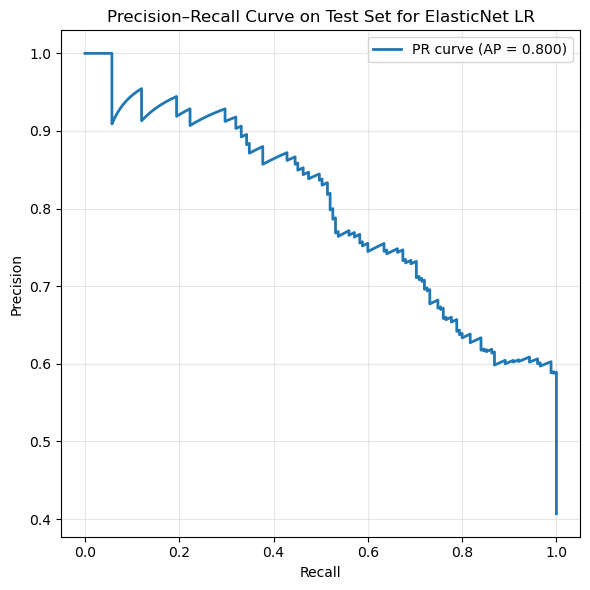

In [28]:
from sklearn.metrics import precision_recall_curve
# 1) Get out-of-fold probabilities on TRAINING data
# (uses the same CV you used before, but now for predict_proba)
y_train_oof = cross_val_predict(
    best_lr,              # your best_lr from GridSearchCV
    X_train_proc, 
    y_train, 
    cv=5, 
    method="predict_proba",
    n_jobs=-1
)[:,1]

# 2) Find the threshold on TRAIN that maximizes F1
precision, recall, thresholds = precision_recall_curve(y_train, y_train_oof)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx  = np.argmax(f1_scores)
best_thr  = thresholds[best_idx]
best_f1   = f1_scores[best_idx]
print(f"Validation-optimal threshold: {best_thr:.3f}  →  F1 = {best_f1:.3f}")

# 3) Apply that threshold to the TEST set
y_test_proba = best_lr.predict_proba(X_test_proc)[:,1]
y_test_pred  = (y_test_proba >= best_thr).astype(int)

# 4) Compute and report test metrics at this tuned threshold
precision_t = precision_score(y_test, y_test_pred)
recall_t    = recall_score(y_test, y_test_pred)
f1_t        = f1_score(y_test, y_test_pred)
acc_t       = accuracy_score(y_test, y_test_pred)
ap_test     = average_precision_score(y_test, y_test_proba)

# 4) Report
print("\nTest set @ tuned threshold:")
print(f"Test AP:        {ap_test:.3f}")
print(f"Test F1 (0.5):  {f1_test:.3f}")
print(f"Precision (0.5):{prec_test:.3f}")
print(f"Recall (0.5):   {rec_test:.3f}")
print(f"Accuracy:       {acc_test:.3f}")

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP = {ap_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve on Test Set for ElasticNet LR')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('graphs/PR curve', dpi=300, bbox_inches='tight')
plt.show()

,gc_content_difference,intergenic_distance,overlap_length,regdb_tf_hits,genes_overlap
gc_content_difference,1.000000,-0.006524,-0.005320,-0.010891,0.020938
intergenic_distance,-0.006524,1.000000,0.760074,0.455796,-0.002835
overlap_length,-0.005320,0.760074,1.000000,-0.003320,0.059584
regdb_tf_hits,-0.010891,0.455796,-0.003320,1.000000,-0.055725
genes_overlap,0.020938,-0.002835,0.059584,-0.055725,1.000000


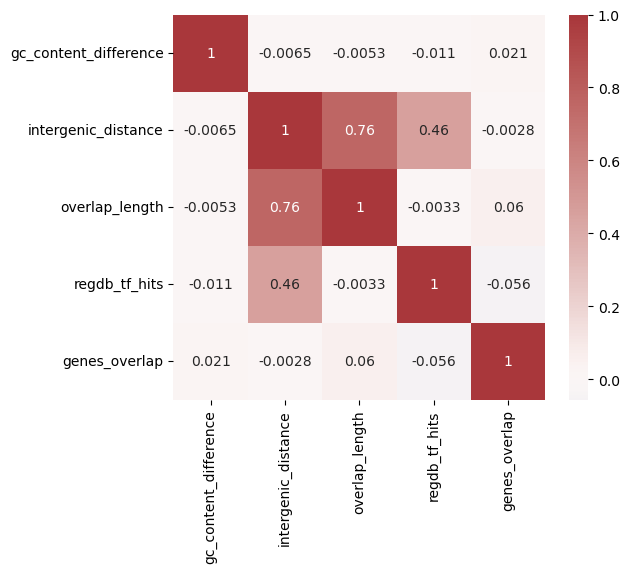

In [29]:
import seaborn as sns
num_cols = ["gc_content_difference","intergenic_distance","overlap_length","regdb_tf_hits","genes_overlap"]
corr = pairs_df[num_cols].corr()
display(corr)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="vlag", center=0)
plt.show()

                         feature  mean_abs_shap
0   remainder__strand_concordant       1.319592
1             num__genes_overlap       1.187310
2      remainder__orientation_++       1.027298
3      remainder__orientation_-+       0.705681
4      remainder__orientation_+-       0.419109
5         remainder__COG_similar       0.418041
6                   cat__COG_B_S       0.233583
7                   cat__COG_A_S       0.136864
8                 cat__COG_B_nan       0.115023
9            num__overlap_length       0.097353
10                  cat__COG_A_K       0.070556
11                  cat__COG_A_C       0.062507
12                  cat__COG_B_K       0.054500
13     remainder__orientation_--       0.053013
14                cat__COG_A_nan       0.043904
15  remainder__has_regdb_tf_site       0.042057
16                  cat__COG_A_L       0.036701
17                  cat__COG_A_G       0.032823
18                cat__COG_A_EGP       0.031629
19                  cat__COG_B_E       0

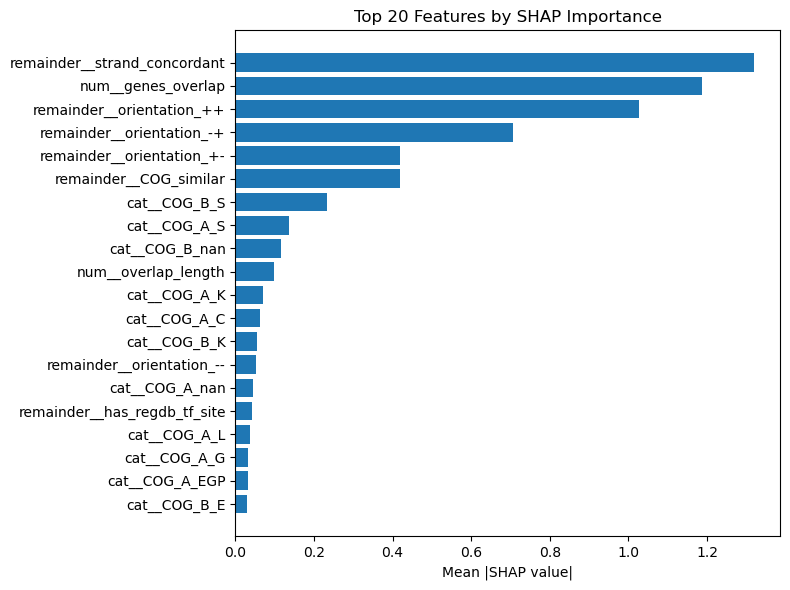

In [30]:
# 1) Compute SHAP values on your preprocessed training set
explainer = shap.LinearExplainer(
    best_lr,                # your trained LogisticRegression
    shap.maskers.Independent(data=X_train_proc)
)
shap_vals = explainer.shap_values(X_train_proc)  # shape = (n_samples, n_features)

# 2) Build a DataFrame of mean(|SHAP|) per feature
feature_names = preprocessor.get_feature_names_out()  # list of column names
mean_imp = np.abs(shap_vals).mean(axis=0)

shap_df = pd.DataFrame({
    "feature":        feature_names,
    "mean_abs_shap":  mean_imp
}).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# 3) Peek at the top 20
print(shap_df.head(20))

# 4) Plot a bar chart of the top 20
plt.figure(figsize=(8,6))
plt.barh(
    shap_df["feature"].iloc[:20][::-1],
    shap_df["mean_abs_shap"].iloc[:20][::-1]
)
plt.xlabel("Mean |SHAP value|")
plt.title("Top 20 Features by SHAP Importance")
plt.tight_layout()
plt.savefig('graphs/SHAP_bar_plot', dpi=300, bbox_inches='tight')
plt.show()

SHAP‑weighted (no pruning) Test results:
Test AP:        0.796
Test F1 (0.5):  0.714
Precision (0.5):0.620
Recall (0.5):   0.840
Accuracy:       0.726


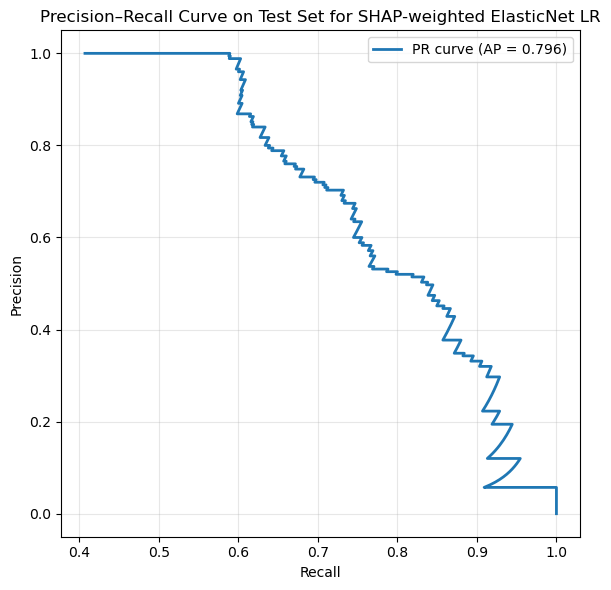

In [31]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score, accuracy_score

# make sure these exist in your namespace:
y_train_arr = y_train.values if hasattr(y_train, "values") else y_train
y_test_arr  = y_test.values  if hasattr(y_test,  "values") else y_test

# 1) Build per-feature C_j with lb=0.5
base_C   = best_lr.C
imp_norm = (mean_imp - mean_imp.min())/(mean_imp.max() - mean_imp.min())
lb       = 0.5
C_j_full = base_C * (lb + (1 - lb) * imp_norm)

# 2) Scale *all* features by 1/sqrt(C_j) (no pruning)
Xsw_train = X_train_proc.astype(float).copy()
Xsw_test  = X_test_proc.astype(float).copy()
for j in range(Xsw_train.shape[1]):
    factor = np.sqrt(C_j_full[j])
    Xsw_train[:, j] /= factor
    Xsw_test[:,  j] /= factor

# 3) Fit elastic‑net LR with C=1, same l1_ratio
shap_lr = LogisticRegression(
    penalty="elasticnet", solver="saga",
    C=1.0, l1_ratio=best_lr.l1_ratio,
    max_iter=5000, class_weight="balanced"
)
shap_lr.fit(Xsw_train, y_train_arr)

# 4) Evaluate on test
y_proba = shap_lr.predict_proba(Xsw_test)[:,1]
y_pred  = (y_proba >= 0.5).astype(int)

# 4) Compute and report test metrics at this tuned threshold
precision_t = precision_score(y_test_arr, y_pred)
recall_t    = recall_score(y_test_arr,   y_pred)
f1_t        = f1_score(y_test_arr,   y_pred)
acc_t       = accuracy_score(y_test_arr, y_test_pred)
ap_test     = average_precision_score(y_test_arr, y_proba)

# 4) Report
print("SHAP‑weighted (no pruning) Test results:")
print(f"Test AP:        {ap_test:.3f}")
print(f"Test F1 (0.5):  {f1_test:.3f}")
print(f"Precision (0.5):{prec_test:.3f}")
print(f"Recall (0.5):   {rec_test:.3f}")
print(f"Accuracy:       {acc_test:.3f}")

precision, recall, thresholds = precision_recall_curve(y_test_arr, y_test_proba)
plt.figure(figsize=(6,6))
plt.plot(precision, recall, lw=2, label=f'PR curve (AP = {ap_test:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve on Test Set for SHAP-weighted ElasticNet LR')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('graphs/PR curve SHAP', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# Build C_j_full and scale ALL features (no pruning)
base_C   = best_lr.C
imp_norm = (mean_imp - mean_imp.min())/(mean_imp.max() - mean_imp.min())
lb       = 0.5
C_j_full = base_C * (lb + (1 - lb)*imp_norm)

Xsw = X_train_proc.astype(float).copy()
for j in range(Xsw.shape[1]):
    Xsw[:, j] /= np.sqrt(C_j_full[j])

# 1) Split off a small val set for threshold tuning
X_sub, X_val, y_sub, y_val = train_test_split(
    Xsw, y_train_arr,
    test_size=0.1,
    stratify=y_train_arr,
    random_state=42
)

# 2) Fit on the sub‑training fold
clf = LogisticRegression(
    penalty="elasticnet", solver="saga",
    C=1.0, l1_ratio=best_lr.l1_ratio,
    max_iter=5000, class_weight="balanced"
)
clf.fit(X_sub, y_sub)

# 3) Get validation probabilities
val_proba = clf.predict_proba(X_val)[:,1]

# 4) Sweep thresholds for best F1 on the val set
import numpy as np
ths = np.linspace(0.01, 0.99, 99)
best_th, best_f1 = 0.5, 0.0

for t in ths:
    preds = (val_proba >= t).astype(int)
    f1 = f1_score(y_val, preds)
    if f1 > best_f1:
        best_f1, best_th = f1, t

print(f"Optimal validation threshold = {best_th:.3f} with F1 = {best_f1:.3f}")

# 5) Retrain on ALL of Xsw (full training data), then evaluate on test
clf.fit(Xsw, y_train_arr)
Xsw_test = X_test_proc.astype(float).copy()
for j in range(Xsw_test.shape[1]):
    Xsw_test[:, j] /= np.sqrt(C_j_full[j])

test_proba = clf.predict_proba(Xsw_test)[:,1]
test_pred  = (test_proba >= best_th).astype(int)

print("\nSHAP‑weighted LR @ tuned threshold on TEST:")
print(f"  AP:        {average_precision_score(y_test_arr, test_proba):.3f}")
print(f"  F1:        {f1_score(y_test_arr,   test_pred):.3f}")
print(f"  Precision: {precision_score(y_test_arr, test_pred):.3f}")
print(f"  Recall:    {recall_score(y_test_arr,   test_pred):.3f}")
print(f"  Accuracy:  {(test_pred == y_test_arr).mean():.3f}")

Optimal validation threshold = 0.420 with F1 = 0.791

SHAP‑weighted LR @ tuned threshold on TEST:
  AP:        0.796
  F1:        0.723
  Precision: 0.603
  Recall:    0.903
  Accuracy:  0.719
